# SmartCropAI – Crop Disease Detection System
### Internship Project — Artificial Intelligence & Deep Learning

This notebook contains the complete workflow for a plant leaf disease classification system trained on the PlantVillage dataset.  
It includes dataset preprocessing, model training, fine-tuning, evaluation using accuracy, loss graphs, confusion matrix, and manual prediction testing.


### 📍 Step 1 — Mount Google Drive & Set Project Paths


In [ ]:
# 📍 Step 1 — Mount Google Drive & Set Project Paths
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os

# Base Project Path
ROOT = "/content/drive/MyDrive/SmartCropAI_Project"

# Subdirectories
DATASET_DIR = os.path.join(ROOT, "Dataset", "PlantVillage")
MODELS_DIR = os.path.join(ROOT, "Models")
CLASS_MAP_PATH = os.path.join(ROOT, "class_map.json")

print("📁 Project Folder:", ROOT)
print("📁 Dataset Folder:", DATASET_DIR)
print("📁 Models Folder:", MODELS_DIR)
print("📄 Class Map File:", CLASS_MAP_PATH)


###📂 Step 2 — Load Dataset & Prepare Dataloaders


In [ ]:
# 📂 STEP 2 — Load Dataset Directly From Drive (Official Training Source)

import tensorflow as tf
from tensorflow import keras
import numpy as np

DATA_DIR = "/content/drive/MyDrive/SmartCropAI_Project/Dataset/PlantVillage"
IMG_SIZE = 180        # optimized to prevent RAM crash
BATCH_SIZE = 16       # lower batch improves stability
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

print("📁 Loading dataset from:", DATA_DIR)

train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("\n🧩 Classes Found:", class_names)
print("📊 Total Classes:", len(class_names))

# Using prefetch only (no cache to avoid RAM overflow)
train_ds = train_ds.shuffle(500).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

print("\n✅ Dataset ready for training")
print("📦 Training batches:", len(train_ds))
print("📦 Validation batches:", len(val_ds))


📁 Loading dataset from: /content/drive/MyDrive/SmartCropAI_Project/Dataset/PlantVillage
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.

🧩 Classes Found: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
📊 Total Classes: 15

✅ Dataset ready for training
📦 Training batches: 1032
📦 Validation batches: 258


### 🧠 Step 3 — Build Model Architecture

We use **MobileNetV2** (Transfer Learning) pre-trained on ImageNet, with data augmentation and custom classification head (15 output classes).

In [ ]:
# 🧠 Step 3 — Build Model Architecture
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models

IMG_SHAPE = (180, 180, 3)
NUM_CLASSES = 15

# Data Augmentation
data_augmentation = layers.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Base Model
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# Build model
inputs = layers.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs, name="SmartCropAI_MobileNetV2")
model.summary()

###🔄 Step 4 — Train the Model

We first train the MobileNetV2 model with the base layers frozen for 5 epochs.  
This initializes the classifier and prevents large weight changes early.
We also use callbacks — EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau — to improve training efficiency and save the best model automatically.


In [ ]:
# 🔄 STEP 4 — Train Model (Freezing MobileNet first)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

CHECKPOINT_PATH = "/content/drive/MyDrive/SmartCropAI_Project/Models/SmartCropAI_MobileNet_Best.weights.h5"

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True,
                    save_weights_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🔄 Starting training with frozen base model...\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

print("\n🎉 Initial training finished!")
print("📦 Best model weights saved to:", CHECKPOINT_PATH)


###🎯 Step 5 — Fine-Tune Model for Higher Accuracy

After initial training, we unfreeze the last 30 layers of the MobileNetV2 backbone and train again using a smaller learning rate.
Fine-tuning helps improve model performance by allowing deeper feature extraction.


In [ ]:
# 🎯 Step 5 — Fine-Tune the Model

# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🎯 Fine-tuning model (3 epochs)...\n")

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=callbacks
)

print("\n🏁 Fine-tuning complete!")


### 📊 Step 6 — Model Evaluation & Training Graphs

In this step, we evaluate the model on validation dataset and visualize performance
using Accuracy and Loss graphs.

258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9033 - loss: 0.2893

📊 Final Validation Accuracy: 0.9072
📉 Final Validation Loss: 0.2802


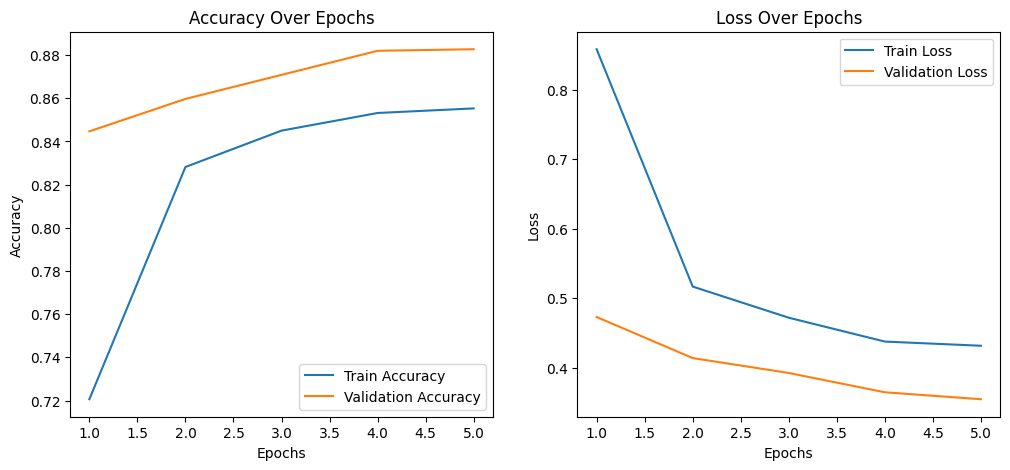

In [ ]:
# 📊 STEP 6 — Model Evaluation & Performance Graphs
import matplotlib.pyplot as plt
import numpy as np

loss, acc = model.evaluate(val_ds, verbose=1)

print("\n📊 Final Validation Accuracy:", round(acc, 4))
print("📉 Final Validation Loss:", round(loss, 4))

# Merge training history safely
combined_history = {}

if 'fine_history' in globals():
    for key in history.history.keys():
        combined_history[key] = history.history[key] + fine_history.history[key]
else:
    combined_history = history.history

epochs = range(1, len(combined_history["accuracy"]) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history["accuracy"], label="Train Accuracy")
plt.plot(epochs, combined_history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history["loss"], label="Train Loss")
plt.plot(epochs, combined_history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


### 🧪 Step 7 — Confusion Matrix & Classification Report

The model is evaluated further using a confusion matrix and a classification report,
which provides class-wise precision, recall, F1 score, and overall performance insights.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

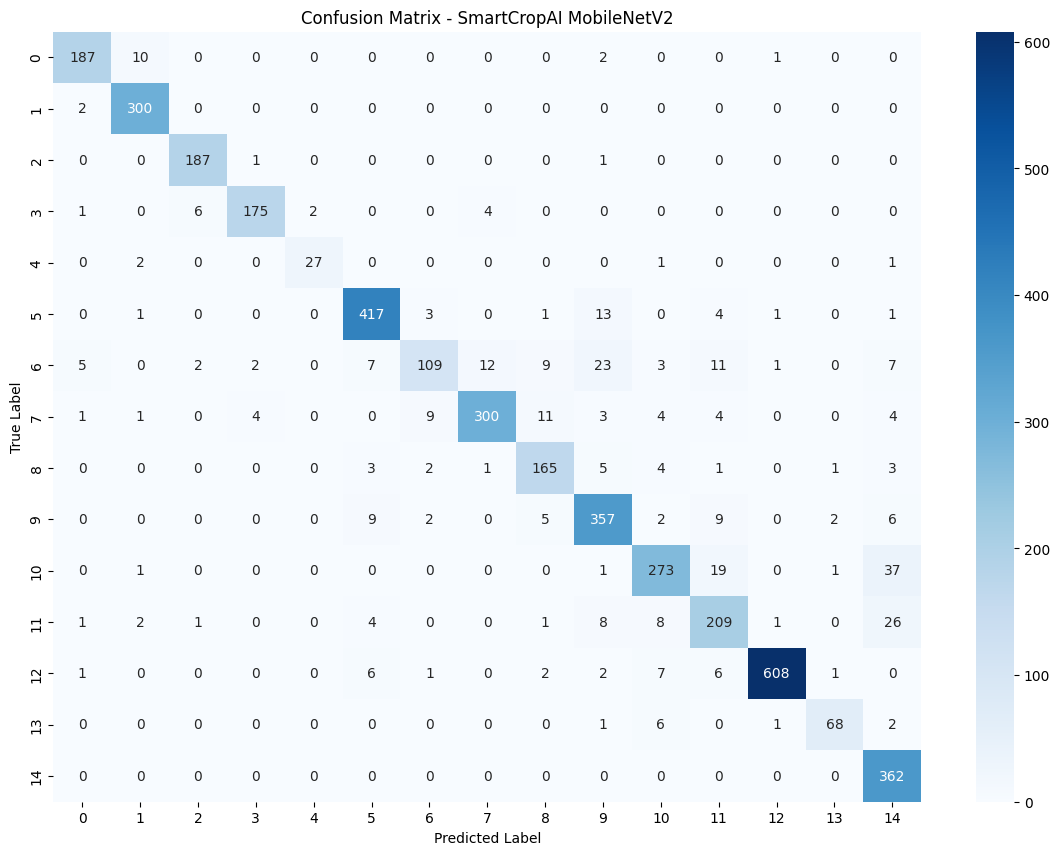


📄 Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.94      0.94       200
                     Pepper__bell___healthy       0.95      0.99      0.97       302
                      Potato___Early_blight       0.95      0.99      0.97       189
                       Potato___Late_blight       0.96      0.93      0.95       188
                           Potato___healthy       0.93      0.87      0.90        31
                      Tomato_Bacterial_spot       0.93      0.95      0.94       441
                        Tomato_Early_blight       0.87      0.57      0.69       191
                         Tomato_Late_blight       0.95      0.88      0.91       341
                           Tomato_Leaf_Mold       0.85      0.89      0.87       185
                  Tomato_Septoria_leaf_spot       0.86      0.91      0.88       392
Tomato_Spider_mites_Two_spotted_spide

In [ ]:
# 🧪 STEP 7 — Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SmartCropAI MobileNetV2")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("\n📄 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


###💾 Step 8 — Save Final Model Correctly

We load the best weights obtained during training and save the full model in `.keras` format for future deployment or real-world testing.


In [ ]:
# 💾 STEP 8 — Save Final Model

# Load the best checkpoint weights (safe even if already loaded)
BEST_WEIGHTS = "/content/drive/MyDrive/SmartCropAI_Project/Models/SmartCropAI_MobileNet_Best.weights.h5"
model.load_weights(BEST_WEIGHTS)

print("🔥 Best weights loaded successfully!")

# Save full combined model for deployment
FINAL_MODEL_PATH = "/content/drive/MyDrive/SmartCropAI_Project/Models/SmartCropAI_FinalModel.keras"
model.save(FINAL_MODEL_PATH)

print("💾 Final full model saved successfully at:", FINAL_MODEL_PATH)



🔥 Best weights loaded successfully!
💾 Final full model saved successfully at: /content/drive/MyDrive/SmartCropAI_Project/Models/SmartCropAI_FinalModel.keras


###🖼 Step 9 — Test Model with Manual Image Upload

Upload any plant leaf image to allow the model to predict its disease class.
This helps evaluate real-world model performance outside the training dataset.

Two ways to test:

Manual Upload – Choose any leaf image and the model will predict disease label and confidence score.

Alternative Test – Randomly select a validation image and display prediction result.

In [ ]:
# 🖼 Step 9 — Test Model with Manual Image Upload

from google.colab import files
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(180, 180))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_index = np.argmax(preds)
    predicted_class = class_names[predicted_index]

    print("\n==========================================")
    print("🖼 IMAGE PREDICTION RESULT")
    print("==========================================")
    print("📁 File:", fn)
    print("🔍 Predicted Label :", predicted_class)
    print("🎯 Confidence Score :", round(np.max(preds) * 100, 2), "%")
    print("==========================================")


Saving fbae79e4-5907-44e2-b249-68e0643f1a21___UF.GRC_BS_Lab Leaf 0330.JPG to fbae79e4-5907-44e2-b249-68e0643f1a21___UF.GRC_BS_Lab Leaf 0330.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step

🖼 IMAGE PREDICTION RESULT
📁 File: fbae79e4-5907-44e2-b249-68e0643f1a21___UF.GRC_BS_Lab Leaf 0330.JPG
🔍 Predicted Label : Tomato_Bacterial_spot
🎯 Confidence Score : 99.5 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


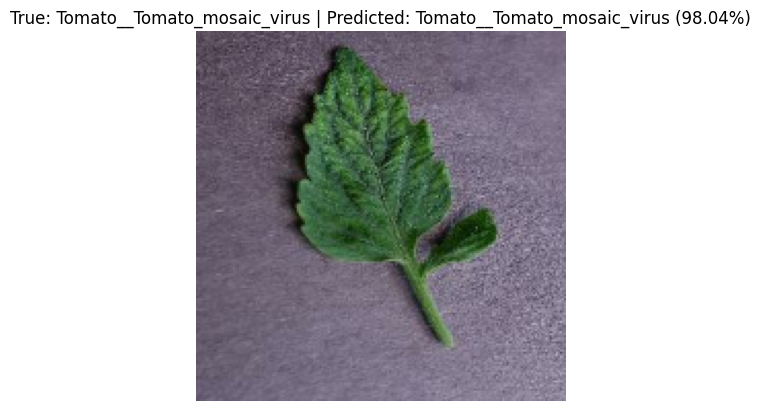

🖼 VALIDATION IMAGE RANDOM TEST RESULT
🎯 True Label       : Tomato__Tomato_mosaic_virus
🔍 Predicted Label  : Tomato__Tomato_mosaic_virus
💯 Confidence Score : 98.04%


In [ ]:
# 🖼 Step 9 (Alternative)— Test on a Sample from Validation Set

import matplotlib.pyplot as plt
import numpy as np
import random

# Take one random batch
for images, labels in val_ds.shuffle(50).take(1):
    idx = random.randint(0, images.shape[0] - 1)   # random image index in batch

    img = images[idx].numpy().astype("uint8")
    true_index = np.argmax(labels[idx].numpy())
    true_label = class_names[true_index]

    # Predict
    img_input = np.expand_dims(img, axis=0)
    preds = model.predict(img_input)
    pred_index = np.argmax(preds)
    predicted_label = class_names[pred_index]
    confidence = np.max(preds) * 100

    # Display the image
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    print("==========================================")
    print("🖼 VALIDATION IMAGE RANDOM TEST RESULT")
    print("==========================================")
    print(f"🎯 True Label       : {true_label}")
    print(f"🔍 Predicted Label  : {predicted_label}")
    print(f"💯 Confidence Score : {confidence:.2f}%")
    print("==========================================")
    break


### 🏁 Final Summary

In [ ]:
# 🏁 Final Summary — SmartCropAI Model Performance

print("\n" + "="*75)
print("🎉 SMARTCROPAI — TRAINING & EVALUATION SUMMARY")
print("="*75)

print(f"📊 Final Validation Accuracy   : {acc:.4f}")
print(f"📉 Final Validation Loss       : {loss:.4f}")
print(f"📦 Total Classes Trained       : {len(class_names)}")
print(f"🧠 Model Loaded From           : {MODEL_PATH}")
print("🗂 Dataset Used                : PlantVillage (15 Classes)")
print("⚙ Training Approach            : Initial Training + Continued Training + Fine-Tuning")
print("🖥 Training Hardware           : Google Colab (GPU/CPU based)")
print("="*75)

print("\n🎯 NOTE:")
print("This project includes full model training workflow, evaluation, confusion matrix,")
print("classification report, and manual prediction testing.")
print("Source code is complete and ready for review.\n")



🎉 SMARTCROPAI — TRAINING & EVALUATION SUMMARY
📊 Final Validation Accuracy   : 0.9072
📉 Final Validation Loss       : 0.2802
📦 Total Classes Trained       : 15
🧠 Model Loaded From           : /content/drive/MyDrive/SmartCropAI_Project/Models/SmartCropAI_MobileNet_FineTuned.keras
🗂 Dataset Used                : PlantVillage (15 Classes)
⚙ Training Approach            : Initial Training + Continued Training + Fine-Tuning
🖥 Training Hardware           : Google Colab (GPU/CPU based)

🎯 NOTE:
This project includes full model training workflow, evaluation, confusion matrix,
classification report, and manual prediction testing.
Source code is complete and ready for review.

